# Introduction
Nous allons ici développer un algorithme de Machine Learning destiné à assigner automatiquement plusieurs tags pertinents à une question posée sur le célébre site Stack overflow.     
Ce programme s'adresse principalement aux nouveaux utilisateurs, afin de leur suggérer quelques tags relatifs à la question qu'ils souhaitent poser.

### Les données sources
Les données ont été cleanées. Dans ce nettoyage ont par exemple été appliquées les techniques de stop words, suppression de la ponctuation et des liens, tokenisation, lemmatisation ...

### Objectif de ce Notebook
Dans ce Notebook, nous allons traiter la partie modélisation des données textuelles avec des modèles supervisés et non supervisés.     

In [49]:
# Install package for PEP8 verification
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

Looking in indexes: https://test.pypi.org/simple/


In [50]:
!pip install gensim

In [51]:
# Import Python libraries
import os
import warnings
import time
import joblib
import numpy as np
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis
from IPython.core.display import display, HTML

#RNN
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session
from keras import backend as K

# Library for PEP8 standard
from nbpep8.nbpep8 import pep8

In [52]:
warnings.filterwarnings('ignore', category=DeprecationWarning)
plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")
set_config(display='diagram')

In [53]:
data = pd.read_csv("StackOverflow_questions_2009_2020_cleaned.csv", sep=";", index_col=0,
                   converters={"Title": literal_eval,
                               "Body": literal_eval,
                               "Tags": literal_eval}) 
data.head(3)

,Title,Body,Score,Tags
Id,,,,
120,"[aspnet, site, map]","[experience, sql, site, map, provider, default...",21,"[sql, asp.net]"
180,"[function, color, wheel]","[pseudo, time, solution, problem, way, color, ...",53,[algorithm]
260,"[scripting, functionality, net, application]","[game, database, end, trading, card, game, fun...",49,"[c#, .net]"


In [54]:
data.shape

(49603, 4)

Nous allons également créer une variable 'Full_doc' qui accueillera le document complet de chaque item (Title et Body) :

In [55]:
data["Full_doc"] = data["Title"] + data["Body"]
data["Full_doc"].head(3)

Id
120    [aspnet, site, map, experience, sql, site, map...
180    [function, color, wheel, pseudo, time, solutio...
260    [scripting, functionality, net, application, g...
Name: Full_doc, dtype: object

In [56]:
data.head(3)

,Title,Body,Score,Tags,Full_doc
Id,,,,,
120,"[aspnet, site, map]","[experience, sql, site, map, provider, default...",21,"[sql, asp.net]","[aspnet, site, map, experience, sql, site, map..."
180,"[function, color, wheel]","[pseudo, time, solution, problem, way, color, ...",53,[algorithm],"[function, color, wheel, pseudo, time, solutio..."
260,"[scripting, functionality, net, application]","[game, database, end, trading, card, game, fun...",49,"[c#, .net]","[scripting, functionality, net, application, g..."


# Word2Vec

In [57]:
# Define X and y
X = data["Full_doc"]
y = data["Tags"]

In [58]:
# Multilabel binarizer for targets
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(y)
y_binarized = multilabel_binarizer.transform(y)

print("Shape of y: {}".format(y_binarized.shape))

Shape of y: (49603, 50)


In [59]:
# Create train and test split (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y_binarized,
                                                    test_size=0.3, random_state=8)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (34722,)
X_test shape : (14881,)
y_train shape : (34722, 50)
y_test shape : (14881, 50)


In [60]:
from gensim.models import word2vec

model = word2vec.Word2Vec(X_train, window=20,
                          min_count=2, workers=1, )
model.corpus_count

34722

In [61]:
vocab = model.wv.index_to_key
vocab[:5]

['code', 'file', 'way', 'error', 'class']

In [62]:
model.save('X_trained_word2vec.bin')

In [63]:
import numpy

def get_vect(word, model):
    try:
        return model.wv[word]
    except KeyError:
        return numpy.zeros((model.vector_size,))

def sum_vectors(phrase, model):
    return sum(get_vect(w, model) for w in phrase)

def word2vec_features(X, model):
    feats = numpy.vstack([sum_vectors(p, model) for p in X])
    return feats

In [64]:
wv_train_feat = word2vec_features(X_train, model)
wv_train_feat.shape

(34722, 100)

In [65]:
wv_test_feat = word2vec_features(X_test, model)

In [66]:
X_train = wv_train_feat.copy()
X_test = wv_test_feat.copy()

In [67]:
X_train.shape

(34722, 100)

In [68]:
X_test.shape

(14881, 100)

In [69]:
y_train.shape

(34722, 50)

In [70]:
y_test.shape

(14881, 50)

In [71]:
from yellowbrick.text import TSNEVisualizer
from yellowbrick.datasets import load_hobbies
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import scipy as sp

svd = TruncatedSVD(n_components = 51)

svd.fit(sp.sparse.vstack((X_train, X_test)))
X_train = svd.transform(X_train)
X_test = svd.transform(X_test)

#svd.fit(sp.sparse.vstack(X_tfidf))
#X_TSNE = svd.transform(X_tfidf)
#X_TSNE.shape

#vectorizer = CountVectorizer() # This class will transform the words in the text into a word frequency matrix, and the matrix element a[i][j] represents the word frequency of word j under class i text
#truncated_trans = TruncatedSVD(n_components=48)
#truncated_before = vectorizer.fit_transform(X_train)
#truncated = truncated_trans.fit_transform(truncated_before)


#pipe_svd = make_pipeline(CountVectorizer(), TruncatedSVD(n_components=48))
#feat_train_svd_before = pipe_svd.fit(X_train)
#feat_train_svd = pipe_svd.transform(feat_train_svd_before)
#feat_train_svd.shape

In [72]:
print(X_train.shape)
print(X_test.shape)

(34722, 51)
(14881, 51)


# Modèles non supervisés

## Modèle LDA
LDA, ou Latent Derelicht Analysis est un modèle probabiliste qui, pour obtenir des affectations de cluster, utilise deux valeurs de probabilité : P(word | topics) et P(topics | documents). Ces valeurs sont calculées sur la base d'une attribution aléatoire initiale, puis le calcul est répété pour chaque mot dans chaque document, pour décider de leur attribution de sujet. Dans cette méthode itérative, ces probabilités sont calculées plusieurs fois, jusqu'à la convergence de l'algorithme.

Nous allons entrainer 1 seul modèle basé sur la variable Full_doc en utilisant la librairie spécialisée Gensim. Pour cette partie, nous n'utiliserons pas le preprocessing TFIDF mais des fonctions propres aux méthodes Gensim.

Dans une première étape, le Bag of words est créé ainsi que la matrice de fréquence des termes dans les documents :

In [73]:
# Define X and y
X = data["Full_doc"]
y = data["Tags"]

In [74]:
# Create dictionnary (bag of words)
id2word = corpora.Dictionary(X)
id2word.filter_extremes(no_below=4, no_above=0.75, keep_n=None)
# Create Corpus 
texts = X  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 3), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]]


Gensim crée un identifiant unique pour chaque mot du document puis mappe word_id et word_frequency. Exemple : (6,3) ci-dessus indique que word_id 6 apparaît 3 fois dans le document et ainsi de suite.      
Les mots les plus fréquents ont ici aussi été filtrés grâce à la fonction filter_extremes réglée à 75% comme pour le Tfidf.

Pour voir quel mot correspond à un identifiant donné, il faut transmettre l'identifiant comme clé du dictionnaire. Exemple : id2word[4] :

In [75]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('aspnet', 1),
  ('control', 1),
  ('default', 1),
  ('experience', 1),
  ('file', 1),
  ('map', 2),
  ('membership', 1),
  ('menu', 1),
  ('page', 2),
  ('permission', 1),
  ('provider', 1),
  ('site', 3),
  ('sql', 1),
  ('system', 1),
  ('user', 1),
  ('way', 1),
  ('xml', 1)]]

Nous allons à présent entrainer le modèle LDA sur Full_doc puis afficher les métriques : 
- Perplexity :  Log likelihood - Densité de vraisemblance
- Coherence Score : Les mesures de cohérence de topics évaluent un seul topic en mesurant le degré de similitude sémantique entre les mots à score élevé dans ce dernier.

In [76]:
# Build LDA model
full_lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=20,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=4)
# Print Perplexity score
print('\nPerplexity: ', full_lda_model.log_perplexity(corpus))

#Print Coherence Score
coherence_model_lda = CoherenceModel(model=full_lda_model, 
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.090338402188054

Coherence Score:  0.40895744382263005


### Visualisation des résultats de LDA Gensim sur Full_doc avec 20 topics

D'après les résultats de cette modélisation LDA, il semble très difficile de "nommer" les topics créés car les mots qui les composent sont très variés et sans fil conducteur clairement établi. On voit cependant par exemple que le topic représenté par "server" englobe également "database", "sql", "connection" ou encore "query" ce qui est cohérent.

### Amélioration du modèle LDA

Cependant, dans l'algoritmes LDA, nous avons fixé arbitrairement à 20 le paramètre num_topics, qui représente le nombre de topics à créer. 
Afin de sélectionner le meilleur nombre de topics pour nos données, nous allons itérer sur un intervalle de nombre de topics et tester le score de cohérence pour chaque modèle :

In [77]:
pyLDAvis.enable_notebook()
%matplotlib inline

display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

gensimvis.prepare(full_lda_model, corpus, id2word)

C:\Users\jonat\AppData\Roaming\Python\Python38\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
15    -0.091132 -0.150998       1        1  6.817368
5     -0.054627  0.074116       2        1  6.355408
10     0.040938  0.028461       3        1  6.263469
14    -0.024932 -0.067748       4        1  5.986664
8     -0.078289  0.073154       5        1  5.842435
11     0.112458 -0.016197       6        1  5.557296
16    -0.073742  0.034666       7        1  5.461521
9     -0.018207  0.011297       8        1  5.378820
3      0.014025  0.002156       9        1  5.276151
12     0.088244  0.045800      10        1  5.195987
19     0.006622  0.008028      11        1  4.913783
17    -0.047906  0.032762      12        1  4.795037
2     -0.080872  0.059441      13        1  4.743626
1      0.078722  0.008627      14        1  4.436835
6      0.007317 -0.055903      15        1  4.196553
4      0.047319 -0.045977      16        1  4.068699
0      0.024424  0.040935      17        1  3.929587
13    -0.022190 -0.044417      18        1  3.926700
7      0.113630 -0.010814      19        1  3.596246
18    -0.041802 -0.027389      20        1  3.257818, topic_info=       Term          Freq         Total Category  logprob  loglift
59   method  12182.000000  12182.000000  Default  30.0000  30.0000
4      file  18150.000000  18150.000000  Default  29.0000  29.0000
453    list   6355.000000   6355.000000  Default  28.0000  28.0000
249   array   5883.000000   5883.000000  Default  27.0000  27.0000
441   image   6419.000000   6419.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
67      app    259.959750  10309.607410  Topic20  -5.0667  -0.2562
8      page    234.732151   6968.694960  Topic20  -5.1687   0.0334
29    class    238.370395  12198.332750  Topic20  -5.1534  -0.5111
940  button    201.171721   4124.848302  Topic20  -5.3230   0.4035
176   error    205.074277  13438.664288  Topic20  -5.3038  -0.7584

[1673 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
5118     11  0.051413            abi
5118     15  0.874022            abi
3843      2  0.937867       absolute
2633      7  0.027999  accessibility
2633      8  0.055998  accessibility
...     ...       ...            ...
3246     14  0.005350        youtube
3246     15  0.010700        youtube
3246     17  0.042799        youtube
7174      9  0.931189       zipalign
5462      3  0.938948         zipper

[9579 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 6, 11, 15, 9, 12, 17, 10, 4, 13, 20, 18, 3, 2, 7, 5, 1, 14, 8, 19])

In [78]:
# Iter LDA for best number of topics
coherence_test = []
for k in np.arange(1,90,10):
    print("Fitting LDA for K = {}".format(k))
    start_time = time.time()
    lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=k,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=4)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=texts,
                                         dictionary=id2word,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    end_time = time.time()
    coherence_test.append((k, coherence_lda,
                           (end_time - start_time)))

Fitting LDA for K = 1
Fitting LDA for K = 11
Fitting LDA for K = 21
Fitting LDA for K = 31
Fitting LDA for K = 41
Fitting LDA for K = 51
Fitting LDA for K = 61
Fitting LDA for K = 71
Fitting LDA for K = 81


Affichons les scores des divers modèles :

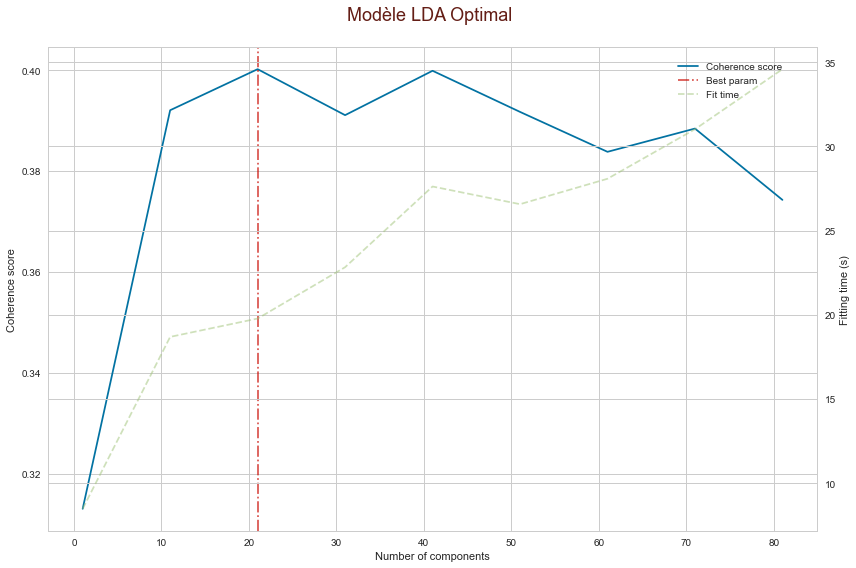

In [79]:
# Create dataframe of results
coherence_test = pd.DataFrame(coherence_test,
                              columns=["k","coherence","time"])

# Select best number of topics
best_nb_topics = coherence_test\
                    .loc[coherence_test.coherence.argmax(),"k"]

# Plot results
fig, ax1 = plt.subplots(figsize=(12,8))
x = coherence_test["k"]
y1 = coherence_test["coherence"]
y2 = coherence_test["time"]

ax1.plot(x, y1, label="Coherence score")
ax1.axvline(x=best_nb_topics, color='r', alpha=.7,
            linestyle='dashdot', label='Best param')
ax1.set_xlabel("Number of components")
ax1.set_ylabel("Coherence score")

ax2 = ax1.twinx()
ax2.plot(x, y2, label="Fit time",
         color='g', alpha=.5,
         linestyle='--')
ax2.set_ylabel("Fitting time (s)")

plt.title("Modèle LDA Optimal \n",
          color="#641E16", fontsize=18)
legend = fig.legend(loc=1, bbox_to_anchor=(.92, .9))

fig.tight_layout()
plt.show()

In [80]:
best_nb_topics

21

Testons à présent le modèle avec le meilleur nombre théorique de topics pour l'afficher avec LDAvis :

In [81]:
# Best LDA visualization
# Construire le modèle LDA
best_lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=best_nb_topics,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=4)
gensimvis.prepare(best_lda_model, corpus, id2word)

C:\Users\jonat\AppData\Roaming\Python\Python38\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
15     0.040408 -0.168173       1        1  6.359230
5      0.057831  0.077427       2        1  6.114593
14     0.028864 -0.068230       3        1  5.816729
11    -0.124609  0.005456       4        1  5.711246
16     0.091650  0.028573       5        1  5.368481
2      0.084491  0.050960       6        1  5.294879
3     -0.014222 -0.006685       7        1  5.258008
10    -0.026161  0.033976       8        1  5.252419
9      0.022691  0.004895       9        1  4.934717
8      0.087626  0.063142      10        1  4.933987
13     0.043583 -0.035377      11        1  4.692635
12    -0.088616  0.041064      12        1  4.681526
19     0.004470 -0.001711      13        1  4.650844
17     0.045652  0.026943      14        1  4.595835
1     -0.074933  0.017439      15        1  4.573840
7     -0.140501  0.019306      16        1  4.240159
6     -0.036981 -0.044663      17        1  3.764933
4     -0.050320 -0.043962      18        1  3.710318
0     -0.027516  0.040059      19        1  3.525695
18     0.040586 -0.029502      20        1  3.353909
20     0.036008 -0.010938      21        1  3.166019, topic_info=         Term          Freq         Total Category  logprob  loglift
4        file  18378.000000  18378.000000  Default  30.0000  30.0000
59     method  12257.000000  12257.000000  Default  29.0000  29.0000
249     array   6126.000000   6126.000000  Default  28.0000  28.0000
18   function  11994.000000  11994.000000  Default  27.0000  27.0000
441     image   6354.000000   6354.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
2     default    198.032141   2933.425852  Topic21  -5.3102   0.7572
14       user    228.769350   9296.244539  Topic21  -5.1659  -0.2520
20    problem    229.273819  10750.866074  Topic21  -5.1637  -0.3951
49       case    208.634764   5439.249027  Topic21  -5.2580   0.1919
115   version    205.044392   5201.066307  Topic21  -5.2754   0.2193

[1760 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3843      2  0.967541  absolute
226       1  0.051957    access
226       2  0.075421    access
226       3  0.043577    access
226       4  0.029610    access
...     ...       ...       ...
5426     10  0.926336       yii
2853      7  0.111834     youre
2853     18  0.782841     youre
7174      7  0.945672  zipalign
5462      9  0.955058    zipper

[10430 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 6, 15, 12, 17, 3, 4, 11, 10, 9, 14, 13, 20, 18, 2, 8, 7, 5, 1, 19, 21])

Pour attribuer des Tags à chaque question sur ces modèles non-supervisés, nous allons créer une matrice Topic/Tags en réalisant une multiplication matricielle des matrices Document / Topic et Document / Tags.

In [82]:
# Calculate Document/topic matrix with Gensim
doc_topic = pd.DataFrame(best_lda_model\
                             .get_document_topics(corpus,
                                                  minimum_probability=0))
for topic in doc_topic.columns:
    doc_topic[topic] = doc_topic[topic].apply(lambda x : x[1])

print('document/tag : ', y_binarized.shape)
print('document/topic : ', doc_topic.shape)

document/tag :  (49603, 50)
document/topic :  (49603, 21)


In [83]:
# Print documents / topic matrix
doc_topic.head(3)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.002165,0.002165,0.002165,0.002165,0.002165,0.002165,0.002165,0.002165,0.253659,0.279878,...,0.002165,0.002165,0.002165,0.002165,0.216670,0.002165,0.212992,0.002165,0.002165,0.002165
1,0.004330,0.004330,0.356255,0.004330,0.004330,0.004330,0.004330,0.004330,0.004330,0.004330,...,0.561476,0.004330,0.004330,0.004330,0.004330,0.004330,0.004330,0.004330,0.004330,0.004330
2,0.138748,0.001084,0.001084,0.001084,0.001084,0.001084,0.001084,0.001084,0.713674,0.001084,...,0.001084,0.001084,0.001084,0.001084,0.001084,0.001084,0.001084,0.001084,0.128070,0.001084


A présent, créons la matrice Topic / Tags grâce aux probabilités obtenues :

In [84]:
# Matricial multiplication with Document / Topics transpose
topic_tag = np.matmul(doc_topic.T, y_binarized)
topic_tag.shape

(21, 50)

In [85]:
topic_tag

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,68.562566,11.741238,5.807391,68.800732,32.038533,8.989209,20.724044,10.094080,45.254951,203.377805,...,22.992366,15.486727,10.854743,7.745939,111.279095,17.687412,30.527146,5.224470,22.547979,11.608852
1,104.906466,68.912691,8.515927,86.447558,23.398734,226.143480,32.438099,23.730052,107.702082,345.357155,...,24.232785,112.593732,51.442351,98.852666,6.677907,13.682955,14.845860,44.824456,22.709155,26.115418
2,59.279499,16.227316,98.735499,722.743545,24.264128,3.764315,14.138250,10.492059,67.284976,138.601526,...,19.602517,9.191840,4.271131,5.919824,9.746558,9.088023,32.691959,10.640009,83.960410,46.210336
3,91.833244,182.460924,19.622775,219.596065,12.541368,40.630980,24.591937,13.777035,104.229828,219.662448,...,13.849539,15.071480,10.088348,21.075208,5.682357,10.589166,20.039921,23.558332,27.870696,7.564524
4,96.215557,55.535278,10.673143,94.428474,18.718194,65.715578,35.347645,51.817633,57.069448,313.814125,...,20.657364,28.284621,14.119472,32.110309,16.783900,7.239540,9.130985,14.748752,12.270221,14.570195
5,197.354602,18.526660,14.153032,131.041386,28.635787,5.992059,110.515130,41.980346,119.552262,375.523054,...,27.248826,41.064632,60.277177,7.239906,118.462356,31.641111,45.072290,11.279436,32.089295,15.622434
6,79.105764,21.436869,32.200166,256.623059,10.824119,14.887063,31.467892,11.637640,42.797006,221.334286,...,15.204757,19.640943,7.833418,140.633507,9.951499,4.498427,6.756580,8.056905,19.230755,21.013111
7,162.356264,10.697362,18.978801,98.110528,10.467472,23.099573,32.981799,26.642436,76.233666,505.342723,...,106.531048,15.167110,7.910770,32.986474,33.245178,11.984491,8.961653,18.465659,19.415595,7.218190
8,97.630644,10.050701,11.851272,258.090006,17.170951,3.910254,57.866811,35.795731,33.654499,182.245407,...,79.098223,25.195787,23.250657,3.407542,18.889220,36.182937,26.760033,13.367644,95.578947,10.998815
9,116.882891,13.791176,7.804000,86.206702,21.356844,5.439206,122.782834,45.347268,19.493641,328.979368,...,7.596079,266.699460,191.905254,4.280383,10.930214,11.588481,22.322044,30.199599,7.767603,7.924364


Nous obtenons donc une matrice dont les lignes représentent les Topics créés et les colonnes les Tags associés et leurs distribution. Nous allons donc créer nos prédictions en prenant les n premiers tags associés aux topics de chaque document :

In [86]:
y_results = pd.DataFrame(y)
y_results["best_topic"] = doc_topic.idxmax(axis=1).values
y_results["nb_tags"] = y_results["Tags"].apply(lambda x : len(x))

df_y_bin = pd.DataFrame(y_binarized)
df_dict = dict(
    list(
        df_y_bin.groupby(df_y_bin.index)
    )
)

tags_num = []
for k, v in df_dict.items():
    check = v.columns[(v == 1).any()]
    tags_num.append(check.to_list())

y_results["y_true"] = tags_num
y_results.head(3)

,Tags,best_topic,nb_tags,y_true
Id,,,,
120,"[sql, asp.net]",9,2,"[6, 41]"
180,[algorithm],11,1,[1]
260,"[c#, .net]",8,2,"[0, 9]"


In [87]:
# Select predicted tags in Topics / Tags matrix
list_tag = []
for row in y_results.itertuples():
    nb_tags = row.nb_tags
    best_topic = row.best_topic
    row_tags = list(topic_tag.iloc[best_topic]\
                    .sort_values(ascending=False)[0:nb_tags].index)
    list_tag.append(row_tags)
    
y_results["y_pred"] = list_tag
y_results.head(3)

,Tags,best_topic,nb_tags,y_true,y_pred
Id,,,,,
120,"[sql, asp.net]",9,2,"[6, 41]","[9, 41]"
180,[algorithm],11,1,[1],[9]
260,"[c#, .net]",8,2,"[0, 9]","[23, 3]"


Nous allons tester plusieurs métriques sur ce modèle LDA :
- Accuracy score :
- F1 score :
- Jaccard similarity score : 
- Recall :
- Precision :

In [88]:
def metrics_score(model, df, y_true, y_pred):
    """Compilation function of metrics specific to multi-label
    classification problems in a Pandas DataFrame.
    This dataFrame will have 1 row per metric
    and 1 column per model tested. 

    Parameters
    ----------------------------------------
    model : string
        Name of the tested model
    df : DataFrame 
        DataFrame to extend. 
        If None : Create DataFrame.
    y_true : array
        Array of true values to test
    y_pred : array
        Array of predicted values to test
    ----------------------------------------
    """
    if(df is not None):
        temp_df = df
    else:
        temp_df = pd.DataFrame(index=["Accuracy", "F1",
                                      "Jaccard", "Recall",
                                      "Precision"],
                               columns=[model])
        
    scores = []
    scores.append(metrics.accuracy_score(y_true, 
                                         y_pred))
    scores.append(metrics.f1_score(y_pred, 
                                   y_true, 
                                   average='weighted'))
    scores.append(metrics.jaccard_score(y_true, 
                                        y_pred, 
                                        average='weighted'))
    scores.append(metrics.recall_score(y_true, 
                                       y_pred, 
                                       average='weighted'))
    scores.append(metrics.precision_score(y_true, 
                                          y_pred, 
                                          average='weighted'))
    temp_df[model] = scores
    
    return temp_df

In [89]:
# Create matrix for pred and true y LDA
lda_y_pred = np.zeros(y_binarized.shape)
n = 0
for row in y_results.y_pred.values:
    for i in range(len(row)):
        lda_y_pred[n,row[i]] = 1
    n+=1
    
lda_y_true = np.zeros(y_binarized.shape)
m = 0
for row in y_results.y_true.values:
    for i in range(len(row)):
        lda_y_true[m,row[i]] = 1
    m+=1

In [90]:
df_metrics_compare = metrics_score("LDA", df=None,
                                   y_true=lda_y_true,
                                   y_pred=lda_y_pred)
df_metrics_compare

C:\Users\jonat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,LDA
Accuracy,0.125779
F1,0.260184
Jaccard,0.086617
Recall,0.205601
Precision,0.192431


On remarque ici que la modélisation non supervisée avec LDA n'est pas adaptée. En effet, le meilleur nombre de topics se situerait à 11, mais l'algorithme ne parvient pas a établir de groupes bien distincts. Un certain nombre de topics sont très regroupés et donc représentés par les mêmes termes.

# Modèles supervisés

## Régression logistique avec multi-labels

Cette technique vise à construire un modèle permettant de prédire / expliquer les valeurs prises par une variable cible qualitative à partir d’un ensemble de variables explicatives quantitatives ou qualitatives encodées.

Pour cette partie sur les modélisations supervisées, nous allons utiliser la variable Full_doc qui regroupe le Title et le Body puis créer un Pipeline qui ne pourra pas inclure la transformation de notre variable cible (MultiLabelBinarizer ne fonctionne pas dans les Pipeline SKlearn).

In [91]:
# Initialize Logistic Regression with OneVsRest
param_logit = {"estimator__C": [100, 10, 1.0, 0.1],
               "estimator__penalty": ["l1", "l2"],
               "estimator__dual": [False],
               "estimator__solver": ["liblinear"]}

multi_logit_cv = GridSearchCV(OneVsRestClassifier(LogisticRegression()),
                              param_grid=param_logit,
                              n_jobs=-1,
                              cv=5,
                              scoring="f1_weighted",
                              return_train_score = True,
                              refit=True)
multi_logit_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'estimator__C': [100, 10, 1.0, 0.1],
                         'estimator__dual': [False],
                         'estimator__penalty': ['l1', 'l2'],
                         'estimator__solver': ['liblinear']},
             return_train_score=True, scoring='f1_weighted')

In [92]:
logit_cv_results = pd.DataFrame.from_dict(multi_logit_cv.cv_results_)
print("-"*50)
print("Best params for Logistic Regression")
print("-" * 50)
logit_best_params = multi_logit_cv.best_params_
print(logit_best_params)

--------------------------------------------------
Best params for Logistic Regression
--------------------------------------------------
{'estimator__C': 0.1, 'estimator__dual': False, 'estimator__penalty': 'l2', 'estimator__solver': 'liblinear'}


In [93]:
logit_cv_results[logit_cv_results["params"]==logit_best_params]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__C,param_estimator__dual,param_estimator__penalty,param_estimator__solver,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
7,167.428134,15.052327,0.058986,0.021355,0.1,False,l2,liblinear,"{'estimator__C': 0.1, 'estimator__dual': False...",0.416561,...,0.418966,0.005958,1,0.428246,0.425448,0.427405,0.429611,0.429883,0.428119,0.001613


Nous pouvons maintenant réaliser les prédictions avec le modèle de régression logistique sur le jeu de test pour pouvoir les comparer avec le jeu y_test.

In [94]:
# Predict
y_test_predicted_labels_tfidf = multi_logit_cv.predict(X_test)

# Inverse transform
y_test_pred_inversed = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_tfidf)
y_test_inversed = multilabel_binarizer\
    .inverse_transform(y_test)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed[0:5])
print("True:", y_test_inversed[0:5])

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [(), ('c++',), ('android',), ('ruby-on-rails',), ('android',)]
True: [('sql-server',), ('c#',), ('android', 'java'), ('javascript', 'jquery', 'ruby-on-rails'), ('android',)]


Puis nous calculons les diverses métriques sur le meilleur modèle de régression logistique :

In [95]:
df_metrics_compare = metrics_score("Logit", 
                                   df=df_metrics_compare, 
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_tfidf)
df_metrics_compare

,LDA,Logit
Accuracy,0.125779,0.214502
F1,0.260184,0.482595
Jaccard,0.086617,0.270885
Recall,0.205601,0.305504
Precision,0.192431,0.643837


## <span id="section_3_2">Modélisation avec RandomForest</span>

In [96]:
# Initialize RandomForest with OneVsRest
param_rfc = {"estimator__max_depth": [5, 25, 50],
             "estimator__min_samples_leaf": [1, 5, 10],
             "estimator__class_weight": ["balanced"]}

multi_rfc_cv = GridSearchCV(OneVsRestClassifier(RandomForestClassifier()),
                            param_grid=param_rfc,
                            n_jobs=-1,
                            cv=2,
                            scoring="f1_weighted",
                            return_train_score = True,
                            refit=True,
                            verbose=3)
# Fit on Sample data
multi_rfc_cv.fit(X_train[0:7000], y_train[0:7000])

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  18 | elapsed:  2.8min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  3.6min finished


GridSearchCV(cv=2,
             estimator=OneVsRestClassifier(estimator=RandomForestClassifier()),
             n_jobs=-1,
             param_grid={'estimator__class_weight': ['balanced'],
                         'estimator__max_depth': [5, 25, 50],
                         'estimator__min_samples_leaf': [1, 5, 10]},
             return_train_score=True, scoring='f1_weighted', verbose=3)

In [97]:
rfc_cv_results = pd.DataFrame.from_dict(multi_rfc_cv.cv_results_)
print("-"*50)
print("Best params for RandomForestClassifier")
print("-" * 50)
rfc_best_params = multi_rfc_cv.best_params_
print(rfc_best_params)

--------------------------------------------------
Best params for RandomForestClassifier
--------------------------------------------------
{'estimator__class_weight': 'balanced', 'estimator__max_depth': 5, 'estimator__min_samples_leaf': 10}


In [98]:
rfc_best_params_ok = {}
for k, v in rfc_best_params.items():
    rfc_best_params_ok[k.replace("estimator__","")] = v

In [99]:
# Refit RandomForestClassifier best_params with full dataset
rfc_final_model = OneVsRestClassifier(RandomForestClassifier(**rfc_best_params_ok))
rfc_final_model.fit(X_train, y_train)

# Predict
y_test_predicted_labels_tfidf_rfc = rfc_final_model.predict(X_test)

# Inverse transform
y_test_pred_inversed_rfc = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_tfidf_rfc)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed_rfc[0:5])
print("True:", y_test_inversed[0:5])

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('asp.net', 'c#', 'mysql', 'php'), ('c', 'c++', 'c++11'), ('c#', 'database', 'java', 'mysql', 'sql', 'sql-server'), ('asp.net-mvc', 'javascript', 'jquery', 'ruby', 'ruby-on-rails'), ('androi', 'android')]
True: [('sql-server',), ('c#',), ('android', 'java'), ('javascript', 'jquery', 'ruby-on-rails'), ('android',)]


In [100]:
df_metrics_compare = metrics_score("RandomForest", 
                                   df=df_metrics_compare,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_tfidf_rfc)
df_metrics_compare

,LDA,Logit,RandomForest
Accuracy,0.125779,0.214502,0.015725
F1,0.260184,0.482595,0.341312
Jaccard,0.086617,0.270885,0.263353
Recall,0.205601,0.305504,0.750172
Precision,0.192431,0.643837,0.291260


Les métriques sur le modèle RandomForest sont moins bonnes mais semblent cependant plus cohérente avec les données, ce d'autant que les métriques Jaccard et F1 sont proches. D'autre part, nous pouvons vérifier le nombre de lignes dont les Tags ne sont pas prédit afin de voir si l'un des modèles est meilleur :

In [101]:
Tags_per_row_lr = y_test_predicted_labels_tfidf.sum(axis=1)
null_rate_lr = round(((Tags_per_row_lr.size - np.count_nonzero(Tags_per_row_lr))
                      /Tags_per_row_lr.size)*100,2)
Tags_per_row_rfc = y_test_predicted_labels_tfidf_rfc.sum(axis=1)
null_rate_rfc = round(((Tags_per_row_rfc.size - np.count_nonzero(Tags_per_row_rfc))
                       /Tags_per_row_rfc.size)*100,2)
print("-"*50)
print("Percentage of non tagged question for each model")
print("-" * 50)
print("Logistic Regression: {}%".format(null_rate_lr))
print("Random Forest: {}%".format(null_rate_rfc))

--------------------------------------------------
Percentage of non tagged question for each model
--------------------------------------------------
Logistic Regression: 55.06%
Random Forest: 0.48%


Le Random Forest semble donc plus approprié à notre programme d'auto-tagging sur les données Stackoverflow. Nous allons à présent tester ce modèle RandomForest avec Classifier Chains pour remplacer la méthode One versus rest :

## Modèle RandomForest avec Classifier Chains

Avec la méthode ClassifierChains, chaque modèle fait une prédiction dans l'ordre spécifié en utilisant toutes les fonctionnalités disponibles fournies au modèle mais également les prédictions des modèles précédents.

In [102]:
rfc_base_model = RandomForestClassifier(**rfc_best_params_ok)
chain = ClassifierChain(rfc_base_model, order='random')
chain.fit(X_train, y_train)

ClassifierChain(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                      max_depth=5,
                                                      min_samples_leaf=10),
                order='random')

In [103]:
# Predict
y_test_predicted_labels_tfidf_chain = chain.predict(X_test)

# Inverse transform
y_test_pred_inversed_chain = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_tfidf_chain)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed_chain[0:5])
print("True:", y_test_inversed[0:5])

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('asp.net', 'c#', 'mysql'), ('c', 'c++', 'c++11'), ('android', 'database', 'java', 'mysql', 'sql'), ('angularjs', 'asp.net-mvc', 'javascript', 'jquery', 'ruby', 'ruby-on-rails'), ('android', 'eclipse')]
True: [('sql-server',), ('c#',), ('android', 'java'), ('javascript', 'jquery', 'ruby-on-rails'), ('android',)]


In [104]:
Tags_per_row_chain = y_test_predicted_labels_tfidf_chain.sum(axis=1)
null_rate_chain = round(((Tags_per_row_chain.size - np.count_nonzero(Tags_per_row_chain))
                       /Tags_per_row_chain.size)*100,2)
print("-"*50)
print("Percentage of non tagged question for chain model")
print("-" * 50)
print("RandomForest with Classifier Chains: {}%".format(null_rate_chain))

--------------------------------------------------
Percentage of non tagged question for chain model
--------------------------------------------------
RandomForest with Classifier Chains: 0.32%


In [105]:
df_metrics_compare = metrics_score("RFC Chains", 
                                   df=df_metrics_compare,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_tfidf_chain)
df_metrics_compare

,LDA,Logit,RandomForest,RFC Chains
Accuracy,0.125779,0.214502,0.015725,0.033734
F1,0.260184,0.482595,0.341312,0.343704
Jaccard,0.086617,0.270885,0.263353,0.267643
Recall,0.205601,0.305504,0.750172,0.707125
Precision,0.192431,0.643837,0.291260,0.304319


Le modèle RandomForest avec Classifier Chains offre des métriques similaires au modèle avec OneVsRest mais le taux de remplissage des valeurs prédites est encore meilleur.

Nous allons à présent tester un dernier modèle d'apprentissage profond avec Keras et un réseau de neurones simple.

## <span id="section_3_4">Réseau de neurones avec Keras</span>

In [106]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def jaccard_m(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

Nous allons définir une fonction pour constuire le réseau de neurones assez simple. RNN avec une couche cachée et complétement connectée. Nous utiliserons également un Dropout pour éviter le sur-apprentissage.

In [107]:
def build_nn(input_dim, hidden_neurons, output_dim):
    """
    Construct a Keras model which will be used to 
    fit/predict in SKlearn pipeline.
    """
    # Create brain
    model = Sequential()
    model.add(layers.Dense(hidden_neurons,
                           input_dim=input_dim,
                           activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(hidden_neurons,
                           input_dim=input_dim,
                           activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(output_dim,
                           activation='softmax'))
    
    # Compile model
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', recall_m, precision_m, f1_m, jaccard_m])
    model.summary()
    
    return model

In [108]:
clear_session()

model_params = {
    'input_dim': X_train.shape[1],
    'hidden_neurons': 150,
    'output_dim': y_train.shape[1]}

keras_model = build_nn(**model_params)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 150)               7800      
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               22650     
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                7550      
Total params: 38,000
Trainable params: 38,000
Non-trainable params: 0
_________________________________________________________________


In [109]:
y_train.shape[1]

50

In [110]:
history = keras_model.fit(X_train, y_train,
                          epochs=20,
                          batch_size=256,
                          verbose=0,
                          validation_data=(X_test, y_test),
                          shuffle=True)

In [111]:
# evaluate the model
scores = keras_model.evaluate(X_test, y_test)
df_metrics_compare["Keras NN"] = [scores[i] for i in [1,4,5,2,3]]
df_metrics_compare

466/466 [==============================] - 0s 598us/step - loss: 0.0601 - accuracy: 0.5136 - recall_m: 0.3137 - precision_m: 0.8096 - f1_m: 0.4489 - jaccard_m: 1.3431


,LDA,Logit,RandomForest,RFC Chains,Keras NN
Accuracy,0.125779,0.214502,0.015725,0.033734,0.513608
F1,0.260184,0.482595,0.341312,0.343704,0.448931
Jaccard,0.086617,0.270885,0.263353,0.267643,1.343105
Recall,0.205601,0.305504,0.750172,0.707125,0.313723
Precision,0.192431,0.643837,0.291260,0.304319,0.809586


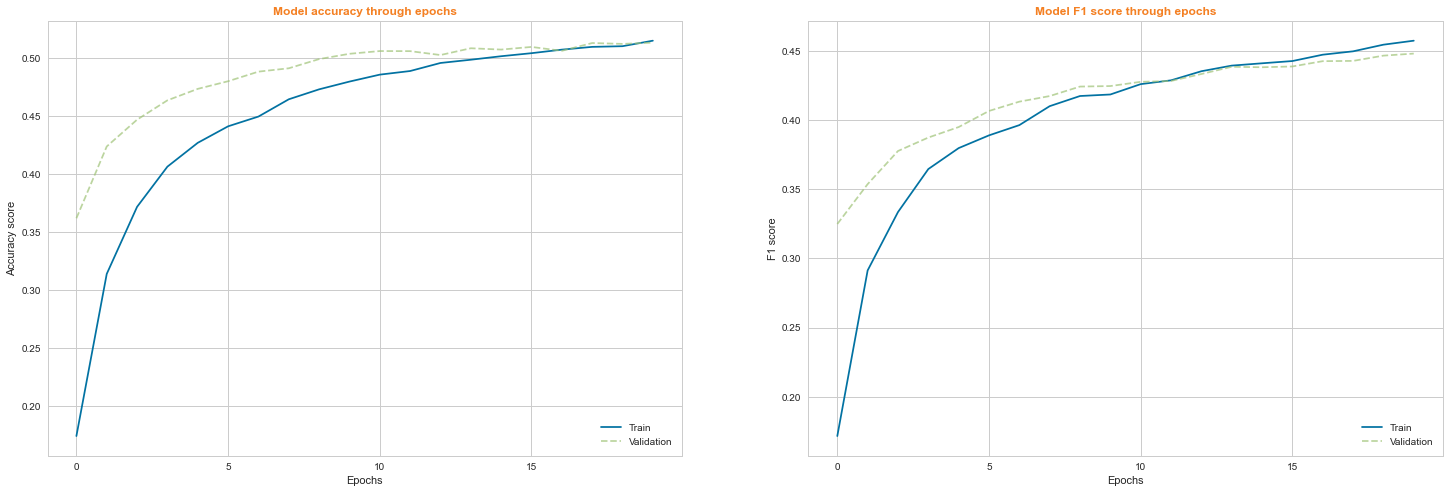

In [112]:
train_accuracy = history.history.get('accuracy', [])
train_f1 = history.history.get('f1_m', [])
val_accuracy = history.history.get('val_accuracy', [])
val_f1 = history.history.get('val_f1_m', [])

fig, axes = plt.subplots(1, 2, figsize=(25, 8))
axes[0].plot(np.arange(0,20,1),
             train_accuracy,
             label="Train")
axes[0].plot(np.arange(0,20,1),
             val_accuracy,
             linestyle='--', color='g', alpha=.7,
             label="Validation")
axes[0].set_xticks(np.arange(0,20,5))
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy score")
axes[0].set_title('Model accuracy through epochs',
                  color='#f48023', fontweight='bold')
axes[0].legend(loc=4)

axes[1].plot(np.arange(0,20,1),
             train_f1, label="Train")
axes[1].plot(np.arange(0,20,1),
             val_f1,
             linestyle='--', color='g', alpha=.7,
             label="Validation")
axes[1].set_xticks(np.arange(0,20,5))
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("F1 score")
axes[1].set_title('Model F1 score through epochs',
                  color='#f48023', fontweight='bold')
axes[1].legend(loc=4)

plt.show()

In [113]:
# Make prediction with Keras Model
y_test_predicted_labels_tfidf_keras = keras_model.predict(X_test)
y_test_predicted_labels_tfidf_keras = np.where(y_test_predicted_labels_tfidf_keras >= 0.5, 1, 0)

In [114]:
# Inverse transform
y_test_pred_inversed_keras = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_tfidf_keras)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed_keras[0:5])
print("True:", y_test_inversed[0:5])

Tags_per_row_keras = y_test_predicted_labels_tfidf_keras.sum(axis=1)
null_rate_keras = round(((Tags_per_row_keras.size - np.count_nonzero(Tags_per_row_keras))
                       /Tags_per_row_keras.size)*100,2)
print("\n")
print("-"*50)
print("Percentage of non tagged question for Keras model")
print("-" * 50)
print("Keras model: {}%".format(null_rate_keras))

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [(), ('c++',), (), ('ruby-on-rails',), ('android',)]
True: [('sql-server',), ('c#',), ('android', 'java'), ('javascript', 'jquery', 'ruby-on-rails'), ('android',)]


--------------------------------------------------
Percentage of non tagged question for Keras model
--------------------------------------------------
Keras model: 47.52%


# Sélection du modèle final

Pour sélectionner le modèle final, nous allons nous baser sur les scores obtenus aux métriques Jaccard et F1. Nous prendrons également en compte le taux de "non prédits" pour trouver le meilleur compromis entre tout ces indicateurs de performance.

In [115]:
import matplotlib.pyplot as plt

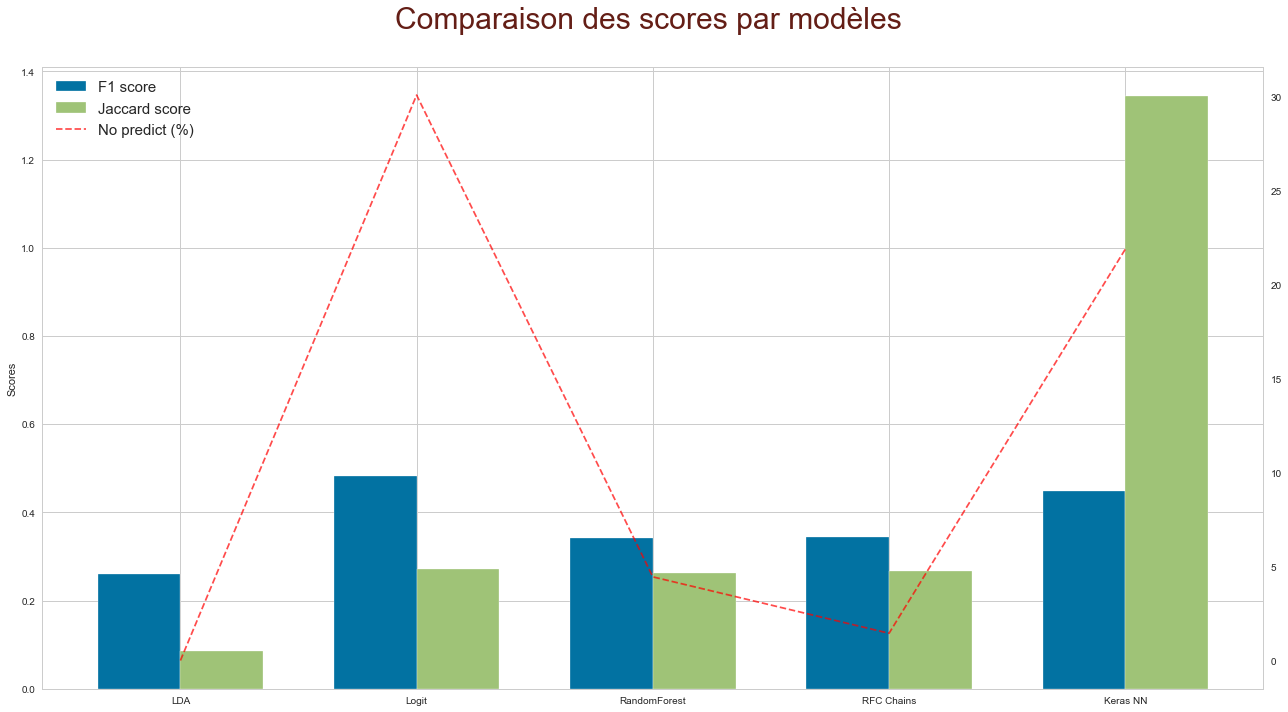

In [116]:
x = np.arange(len(df_metrics_compare.columns))
width = 0.35

fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(111)
f1_scores = ax1.bar(x - width/2, df_metrics_compare.iloc[1,:], width, label="F1 score")
jacc_scores = ax1.bar(x + width/2, df_metrics_compare.iloc[2,:], width, label="Jaccard score")

ax2 = ax1.twinx()
non_predict = ax2.plot(x, [0,30.08,4.45,1.45,21.88],
                       linestyle='--',
                       color="red", alpha=.7,
                       label='No predict (%)')
ax2.grid(None)

ax1.set_ylabel('Scores')
ax1.set_title('Comparaison des scores par modèles \n',
              color="#641E16", 
              fontdict={'fontsize': 30})
ax1.set_xticks(x)
ax1.set_xticklabels(df_metrics_compare.columns)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc=0,
           fontsize=15)

fig.tight_layout()

plt.show()